In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from particletracking import dataframes
from tqdm import tqdm

In [2]:
%matplotlib inline

### Load the datasets

In [3]:
data_flat = dataframes.DataStore("/media/data/Data/FirstOrder/Susceptibility/Flat2/17510001.hdf5")
flat_points = data_flat.df.loc[0].copy()

data_dimpled = dataframes.DataStore("/media/data/Data/FirstOrder/Susceptibility/Dimpled2/17490001.hdf5") 
dimpled_points = data_dimpled.df.loc[0].copy()

### Get all the vectors between the points

In [4]:
def get_delaunay_vectors(points):
    tri = spatial.Delaunay(points[['x', 'y']])
    triangles = tri.points[tri.simplices]
    vecs = np.array([t - t[[2, 0, 1], :] for t in triangles])
    vecs = vecs.reshape((-1, 2))
    return vecs

In [5]:
flat_vecs = get_delaunay_vectors(flat_points)
dimpled_vecs = get_delaunay_vectors(dimpled_points)

### Get all the angles of the vectors

In [6]:
def get_delaunay_angles(vecs):
    return np.arctan(vecs[:, 1]/vecs[:, 0])

In [7]:
flat_angles = get_delaunay_angles(flat_vecs)
dimpled_angles = get_delaunay_angles(dimpled_vecs)

/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


### Calculate the correct angle

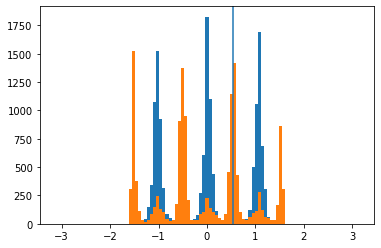

In [8]:
_, _, _ = plt.hist(flat_angles, bins=np.linspace(-np.pi, np.pi, 100))
_, _, _ = plt.hist(dimpled_angles, bins=np.linspace(-np.pi, np.pi, 100))
plt.axvline(np.median(dimpled_angles[(dimpled_angles>0)&(dimpled_angles<np.pi/3)]))

In [9]:
def get_delaunay_angle(angles, flat=False):
    if flat:
        angles = angles[[(angles>-np.pi/4)&(angles<np.pi/4)]]
    else:
        angles = angles[[(angles>0)&(angles<np.pi/3)]]
    return np.median(angles)*180 / np.pi

In [10]:
flat_angle = get_delaunay_angle(flat_angles, True)
dimpled_angle = get_delaunay_angle(dimpled_angles, False)
flat_angle, dimpled_angle

/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


(1.3019526725788753, 30.96375653207352)

### Calculate the correct length

In [11]:
def get_delaunay_lengths(vecs):
    lengths = np.linalg.norm(vecs, axis=1)
    return lengths

In [12]:
flat_lengths = get_delaunay_lengths(flat_vecs)
dimpled_lengths = get_delaunay_lengths(dimpled_vecs)

In [13]:
def get_delaunay_length(lengths):
    return np.median(lengths)

In [14]:
flat_length = get_delaunay_length(flat_lengths)
dimpled_length = get_delaunay_length(dimpled_lengths)

### Calculate G

In [15]:
def get_G(length, angle):
    """Get G from the lengthscale of the lattice and the angle in degrees"""
    a = (angle+90) * np.pi/180 
    cosa = np.cos(a)
    sina = np.sin(a)
    l = 4*np.pi / (length * np.sqrt(3))
    return np.array((cosa, sina))*l

In [16]:
flat_G = get_G(flat_length, flat_angle)
dimpled_G = get_G(dimpled_length, dimpled_angle)

### Calculate translational order

In [17]:
def add_torder(data, G):
    data['torder'] = np.exp(1j* data[['x', 'y']].values@G)
    return data

In [18]:
flat_points = add_torder(flat_points, flat_G)

In [19]:
dimpled_points = add_torder(dimpled_points, dimpled_G)

### Plot translational order

In [20]:
def quiver_torder(data):
    torder = data.torder.values
    plt.quiver(data.x, data.y, torder.real, torder.imag, np.angle(torder), pivot='mid', cmap='hsv')
    plt.clim([-np.pi, np.pi])
    plt.colorbar()

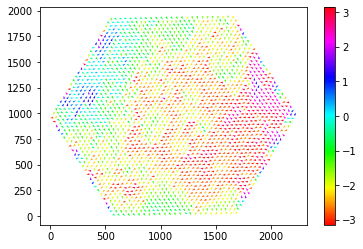

In [21]:
quiver_torder(flat_points)

Using matplotlib backend: Qt5Agg


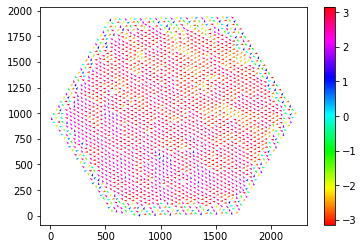

In [22]:
%matplotlib auto
quiver_torder(dimpled_points)

### Calculate for all frames

In [23]:
data_dimpled.df = add_torder(data_dimpled.df, dimpled_G)

In [24]:
data_flat.df = add_torder(data_flat.df, flat_G)

### Calculate the susceptibility

In [25]:
def mean_frame_values(points, param, dist=None):
    if dist is not None:
        points = points.loc[points.edge_distance > dist]
    vals = points[param].values
    return np.mean(vals)

In [26]:
def sus_of_dataframe(data, param, dist=None):
    means = data.df.groupby('frame').apply(mean_frame_values, param, dist)
    sus = np.mean(means * np.conj(means)) - np.mean(means)*np.conj(np.mean(means))
    return sus.real
    

In [27]:
sus = sus_of_dataframe(data_dimpled, 'torder', dist=3*data_dimpled.df.r.mean())

### Calculate the susceptibility for all dataframes to plot the graph

In [28]:
def duty(data):
    return int(data.df.Duty.mean())

In [29]:
import filehandling

In [30]:
flat_files = filehandling.get_directory_filenames("/media/data/Data/FirstOrder/Susceptibility/Flat2/*.hdf5")

In [31]:
dimpled_files = filehandling.get_directory_filenames("/media/data/Data/FirstOrder/Susceptibility/Dimpled2/*.hdf5")

In [176]:
def process_file(file, G):
    data = dataframes.DataStore(file)
    data.df = add_torder(data.df, G)
    data.save()
    d = duty(data)
    sus = sus_of_dataframe(data, 'torder', dist=3*data.df.r.mean())
    return d, sus

In [177]:
flat_duties = []
flat_sus = []
for file in tqdm(flat_files):
    d, sus = process_file(file, flat_G)
    flat_duties.append(d)
    flat_sus.append(sus)

100%|██████████| 100/100 [05:38<00:00,  3.38s/it]


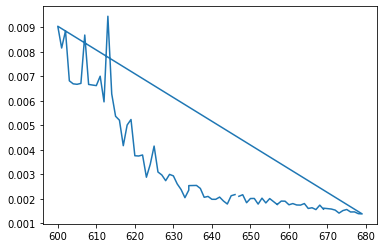

In [35]:
plt.plot(flat_duties, flat_sus)

In [178]:
dimpled_duties = []
dimpled_sus = []
for file in tqdm(dimpled_files):
    d, sus = process_file(file, dimpled_G)
    dimpled_duties.append(d)
    dimpled_sus.append(sus)

100%|██████████| 100/100 [05:38<00:00,  3.38s/it]


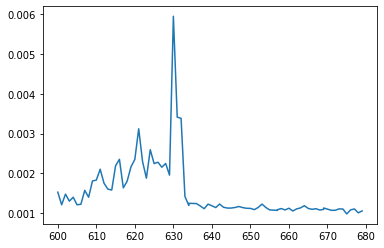

In [36]:
plt.plot(dimpled_duties, dimpled_sus)

### Repeat susceptibility for the hexatic order parameter

In [35]:
def process_file_horder(file):
    data = dataframes.DataStore(file)
    data.df['order_complex_long'] = data.df.order_r_long + 1j*data.df.order_i_long
    d = duty(data)
    sus = sus_of_dataframe(data, 'order_complex_long', dist=3*data.df.r.mean())
    return d, sus

In [36]:
flat_duties_horder = []
flat_sus_horder = []
for file in tqdm(flat_files):
    d, sus = process_file_horder(file)
    flat_duties_horder.append(d)
    flat_sus_horder.append(sus)

100%|██████████| 100/100 [04:29<00:00,  2.70s/it]


In [37]:
dimpled_duties_horder = []
dimpled_sus_horder = []
for file in tqdm(dimpled_files):
    d, sus = process_file_horder(file)
    dimpled_duties_horder.append(d)
    dimpled_sus_horder.append(sus)

100%|██████████| 100/100 [04:29<00:00,  2.69s/it]


### Save the plotting data to file

In [43]:
np.savetxt("/media/data/Data/FirstOrder/Susceptibility/Dataset2Figures/flat_sus_duty", flat_duties)
np.savetxt("/media/data/Data/FirstOrder/Susceptibility/Dataset2Figures/flat_sus_torder", flat_sus)
np.savetxt("/media/data/Data/FirstOrder/Susceptibility/Dataset2Figures/flat_sus_horder", flat_sus_horder)

In [44]:
np.savetxt("/media/data/Data/FirstOrder/Susceptibility/Dataset2Figures/dimpled_sus_duty", dimpled_duties)
np.savetxt("/media/data/Data/FirstOrder/Susceptibility/Dataset2Figures/dimpled_sus_torder", dimpled_sus)
np.savetxt("/media/data/Data/FirstOrder/Susceptibility/Dataset2Figures/dimpled_sus_horder", dimpled_sus_horder)

### Load the plotting data from file

In [ ]:
flat_duties = np.loadtxt("/media/data/Data/FirstOrder/Susceptibility/Dataset2Figures/flat_sus_duty")
flat_sus = np.loadtxt("/media/data/Data/FirstOrder/Susceptibility/Dataset2Figures/flat_sus_torder")
flat_sus_horder = np.loadtxt("/media/data/Data/FirstOrder/Susceptibility/Dataset2Figures/flat_sus_horder")

In [ ]:
dimpled_duties = np.loadtxt("/media/data/Data/FirstOrder/Susceptibility/Dataset2Figures/dimpled_sus_duty")
dimpled_sus = np.loadtxt("/media/data/Data/FirstOrder/Susceptibility/Dataset2Figures/dimpled_sus_torder")
dimpled_sus_horder = np.loadtxt("/media/data/Data/FirstOrder/Susceptibility/Dataset2Figures/dimpled_sus_horder")

### Plot both order sus

In [40]:
plt.rcParams.update({
    'font.size': 14,
    'lines.linewidth': 3,
    'figure.dpi': 100,
    'figure.figsize': (6.4, 4.8)
})

In [41]:
def apply_plot_style(fig, ax1, ax2):
    ax1.set_xlabel('Duty Cycle')
    ax1.set_ylabel('$\chi_T$', c='g')
    ax1.tick_params(axis='y', colors='g')
    ax2.set_ylabel('$\chi_6$', c='m')
    ax2.tick_params(axis='y', colors='m')

In [42]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [42]:
%matplotlib auto
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(flat_duties, flat_sus, 'g-')
ax1.set_title('Flat Data')
ax2.plot(flat_duties, flat_sus_horder, 'm-')
apply_plot_style(fig, ax1, ax2)

Using matplotlib backend: Qt5Agg


In [44]:
fig, ax1 = plt.subplots()
ax1.set_title('Dimpled Data')
ax2 = ax1.twinx()

ax1.plot(dimpled_duties, dimpled_sus, 'g-')
ax2.plot(dimpled_duties_horder, dimpled_sus_horder, 'm-')
apply_plot_style(fig, ax1, ax2)

### What do histograms of translational order look like

In [124]:
def hist_data(file):
    data = dataframes.DataStore(file)
    data.df = add_torder(data.df, flat_G)
    freq, bins = np.histogram(np.angle(data.df.torder.values), bins=np.linspace(-np.pi, np.pi, 360))
    return bins, freq

### Create a video of the quiver plots

In [154]:
from matplotlib.animation import FuncAnimation
import matplotlib

In [126]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm

In [46]:
data_dimpled.df.head()

,x,y,r,Duty,order_r_long,order_i_long,neighbors_long,order_long,order_r_nearest_6,order_i_nearest_6,order_nearest_6,density,shape_factor,on_edge,edge_distance,torder
frame,,,,,,,,,,,,,,,,
0,988,364,18,581.0,-0.890684,-0.127726,6,0.899796,-0.890684,-0.127726,0.899796,0.692909,1.106135,False,358.792297,-0.525843+0.850581j
0,702,1045,18,581.0,-0.973747,-0.157624,6,0.986422,-0.973747,-0.157624,0.986422,0.696607,1.108339,False,569.623596,-0.921525+0.388320j
0,1108,1413,18,581.0,-0.983526,0.058845,6,0.985285,-0.983526,0.058845,0.985285,0.714590,1.106455,False,526.499878,-0.995606-0.093638j
0,1048,931,18,581.0,-0.916762,-0.350467,6,0.981468,-0.916762,-0.350467,0.981468,0.758380,1.103442,False,885.106445,-0.990658+0.136371j
0,1333,535,18,581.0,-0.969027,-0.158846,6,0.981960,-0.969027,-0.158846,0.981960,0.724257,1.105836,False,525.462891,-0.945618+0.325280j


In [173]:
def get_points_and_duty(i):
    file = dimpled_files[i]
    data = dataframes.DataStore(file)
    return data.df.loc[0], data.df.Duty.mean()
    

In [180]:
def get_points_and_duty(i):
#     file = data_dimpled
#     data = dataframes.DataStore(file)
    return data_dimpled.df.loc[i], data_dimpled.df.Duty.mean()

In [183]:
def update(i):
    for artist in ax.collections:
        artist.remove()
    points, duty = get_points_and_duty(i)
    offsets = points[['x', 'y']].values
    x = points.x.values
    y = points.y.values
    t = points['torder'].values
    v = t.imag
    u = t.real
#     Q.set_offsets(offsets)
#     Q.set_UVC(u, v)
    ax.set_title(duty)
    Q = ax.quiver(x, y, u, v, color=cmap(norm(np.angle(t))), pivot='mid')
    

In [184]:
fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [50,1]})
ax.set_aspect('equal')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
cmap = matplotlib.cm.hsv
norm = matplotlib.colors.Normalize(vmin=-np.pi, vmax=np.pi)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
ani = FuncAnimation(fig, update, frames=len(dimpled_files))

In [77]:
ani.save('/home/ppxjd3/TestFolder/test.mp4')

/home/ppxjd3/miniconda3/envs/ExperimentsNew/lib/python3.7/site-packages/matplotlib/quiver.py:670: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/home/ppxjd3/miniconda3/envs/ExperimentsNew/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
